<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brief-background" data-toc-modified-id="Brief-background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brief background</a></span></li><li><span><a href="#Fetch-data" data-toc-modified-id="Fetch-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fetch data</a></span></li><li><span><a href="#Structure-learning" data-toc-modified-id="Structure-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Structure learning</a></span></li></ul></div>

# Brief background

To establish causal relationships between development indicators and mixed-migration, we now model the state of the system as a graphical model. A graphical model is a representation of (conditional) dependence of a set of random variables. 

The framework represents the system as a graph, with **nodes** representing state variables (indicators such as GDP, mixed migration, conflict, etc.) and **edges** representing dependency. Given evidence, such a network can be learnt from the data directly (although this is computationally intensive to explore the possible graph structures as the number of state variables increase). This task is one of *structure learning*. 

If a partial set of dependencies are available from experts, based on domain specific insights or field experience, then the structure can be "bootstrapped" with this dependence structure. Such a structure is shown below:

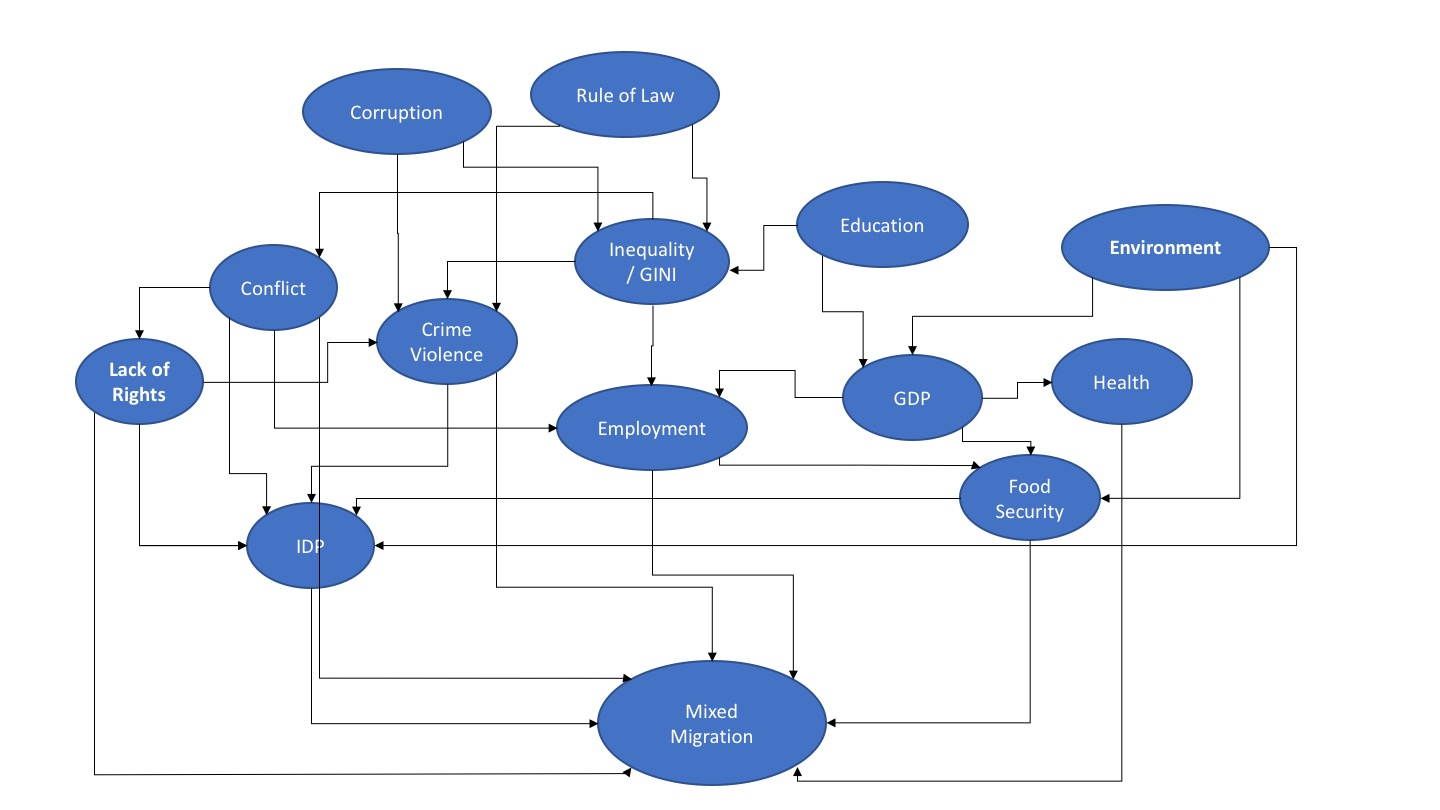

In [89]:
import os
import json
import pandas as pd
import numpy as np
from time import time

from  pomegranate  import BayesianNetwork
import pygraphviz
import networkx
import tempfile

import seaborn as sns
import matplotlib.image as mpl_image
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")

# Fetch data

Review the [README.md](README.md) file on how to download and set up a copy of the pre-processed data. We'll use the [configuration.json](configuration.json) file to gather all the sources.

We focus on 6 bilateral flows for this phase all originating in Ethiopia. The destination countries are: Saudi Arabia, Italy, Great Britain, Denmark, Sweden, and South Africa. These variables are included in the pre-processed dataset and are encoded as `ETH.TO.xxx` (where `xxx` refers to the ISO-3 code of the destination country). 

In [3]:
start_time = time()
with open("configuration.json", 'rt') as infile:
    config = json.load(infile)

S = ['target', 'UN', 'UNHCR', 'worldbank', 'ACLED', 'UN', 'WHO']

sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources'] if (d['name'] in S)]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Row count          : {}".format(len(df)))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))

Sources            : 6
Row count          : 252020
Geographies        : 315
Indicators         : 47
Temporal coverage  : 1950 -> 2018
Null values        : 0

Loaded data in 0.53 sec.


In [6]:
# Indicators being used
df['Indicator Name'].unique()

array(['Mixed migration to Saudi Arabia', 'Mixed migration to Italy',
       'Mixed migration to United Kingdom', 'Mixed migration to Denmark',
       'Mixed migration to Sweden', 'Mixed migration to South Africa',
       'Fertility rate, total (births per woman)', 'Population, total',
       'Rural population', 'Urban population',
       'Urban population growth (annual %)',
       'Individuals using the Internet (% of population)',
       'Food production index (2004-2006 = 100)',
       'Livestock production index (2004-2006 = 100)',
       'Population density (people per sq. km of land area)',
       'Renewable internal freshwater resources per capita (cubic meters)',
       'Water productivity, total (constant 2010 US$ GDP per cubic meter of total freshwater withdrawal)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'GINI index (World Bank estimate)',
       'Battle-related deaths (number of people)',
       'Access to electricity (% of population)',

# Structure learning

What is the relationship between these indicators? We start with a simple model with one country pair and no temporal dependence. One limitation on structure learning is that they work for discrete distributions. So we discretize the state variables first. 

## Discretization


In [ ]:
# Organize the indicators in "long form"
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

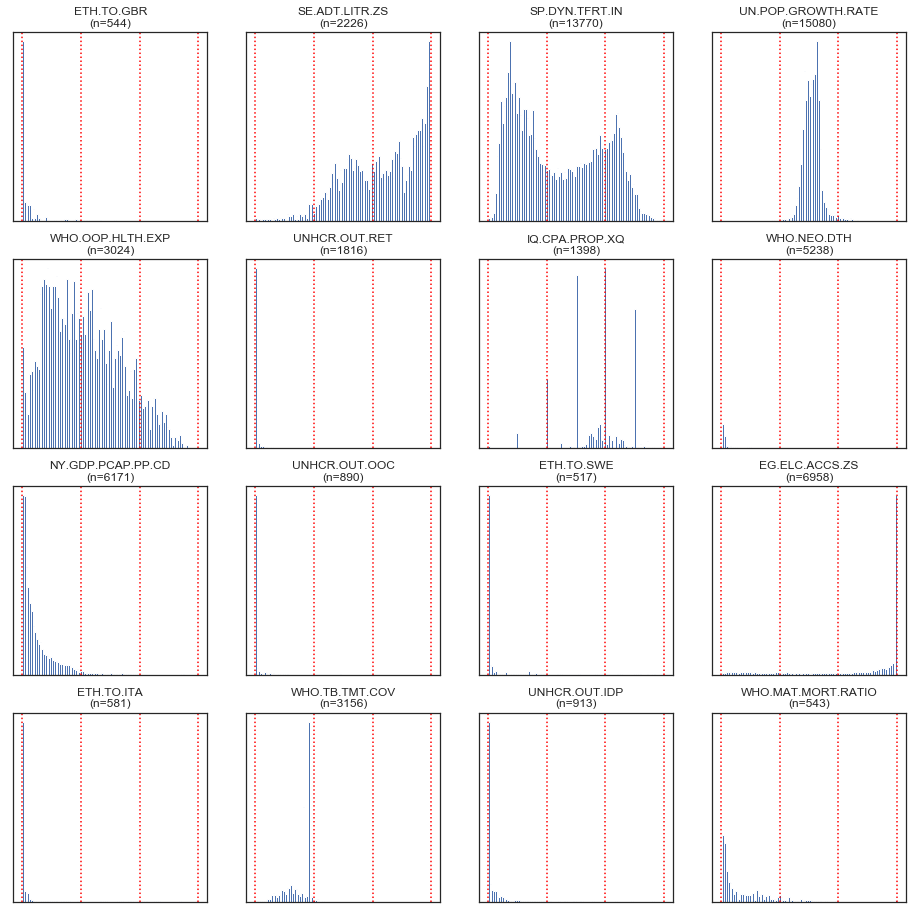

In [71]:
def plot_bins(s, ax, discrete_bins=3, plot_bins=100):
    """ Visualize the raw distribution and bins for indicators """

    
    s.dropna(inplace=True)
    
    # Discretize the series
    _, xbins = pd.cut(s, discrete_bins, retbins=True)
    
    ax.hist(s, bins=plot_bins, density=True)
    ax.set_yticks([], [])
    ax.set_xticks([], [])
    # add reference lines
    [ax.axvline(xb, **{'color': 'red', 'linestyle': 'dotted'}) for xb in xbins]
    
    ax.set_title(s.name + "\n(n={})".format(len(s)))

from random import sample
cols = sample(list(data.columns), k=16)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i, c in enumerate(cols):
    
    plot_bins(data[c], ax=axes[np.unravel_index(i, axes.shape)])
    

In [72]:
# Data transformations for structure learning

# Organize the indicators in "long form"
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Discretization scheme

# TODO: This is primitive, consider:
# - (min-max) after looking at the distributions
# - https://arxiv.org/pdf/1512.02406.pdf 

def discretization(x, BINS=5):
    """ Discretize indicators """
    return pd.cut(x, BINS, labels=False)
    

X = data.apply(discretization, axis=1)

X.head()

Indicator Code     ACLED.COUNT  ACLED.FATALITIES  AG.PRD.FOOD.XD  \
Country Code year                                                  
ABW          1950          NaN               NaN             NaN   
             1951          NaN               NaN             NaN   
             1952          NaN               NaN             NaN   
             1953          NaN               NaN             NaN   
             1954          NaN               NaN             NaN   

Indicator Code     AG.PRD.LVSK.XD  EG.ELC.ACCS.ZS  EN.ATM.PM25.MC.M3  \
Country Code year                                                      
ABW          1950             NaN             NaN                NaN   
             1951             NaN             NaN                NaN   
             1952             NaN             NaN                NaN   
             1953             NaN             NaN                NaN   
             1954             NaN             NaN                NaN   

Indicator Code     EN.POP.DNST  ER.GDP.FWTL.M3.KD  ER.H2O.INTR.PC  ETH.TO.DNK  \
Country Code year                                                               
ABW          1950          NaN                NaN             NaN         NaN   
             1951          NaN                NaN             NaN         NaN   
             1952          NaN                NaN             NaN         NaN   
             1953          NaN                NaN             NaN         NaN   
             1954          NaN                NaN             NaN         NaN   

Indicator Code          ...         WHO.EXT.HTLTH.EXP  WHO.INF.DTH  \
Country Code year       ...                                          
ABW          1950       ...                       NaN          NaN   
             1951       ...                       NaN          NaN   
             1952       ...                       NaN          NaN   
             1953       ...                       NaN          NaN   
             1954       ...                       NaN          NaN   

Indicator Code     WHO.MAT.DEATHS  WHO.MAT.MORT.RATIO  WHO.NEO.DTH  \
Country Code year                                                    
ABW          1950             NaN                 NaN          NaN   
             1951             NaN                 NaN          NaN   
             1952             NaN                 NaN          NaN   
             1953             NaN                 NaN          NaN   
             1954             NaN                 NaN          NaN   

Indicator Code     WHO.NUM.TB.CAS  WHO.OOP.HLTH.EXP  WHO.TB.CAS  \
Country Code year                                                 
ABW          1950             NaN               NaN         NaN   
             1951             NaN               NaN         NaN   
             1952             NaN               NaN         NaN   
             1953             NaN               NaN         NaN   
             1954             NaN               NaN         NaN   

Indicator Code     WHO.TB.TMT.COV  WHO.UND.FIV.DTH  
Country Code year                                   
ABW          1950             NaN              NaN  
             1951             NaN              NaN  
             1952             NaN              NaN  
             1953             NaN              NaN  
             1954             NaN              NaN  

[5 rows x 47 columns]

In [148]:
# Model plot
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

def plot_model(model):
    """ Helper function - due to outdated Networkx dependency """
    
    G = pygraphviz.AGraph(directed=True)
    
    G.node_attr['fontsize'] = '20'
    #G.node_attr['fontcolor']='#FFFFFF'
    
    for state in model.states:
        
        G.add_node(state.name, color='blue', shape='circle')

    for parent, child in model.edges:
        G.add_edge(parent.name, child.name, color='blue')

    """
    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        # plt.savefig("test.png")
    """
    with open("test.png", 'wb') as tf:
        G.draw(tf, format='png', prog='fdp')# , prog='dot')
    

def plot_networkx(Q, node_label=None, edge_label=None, filename=None):
    """ Pomegranate requires Networkx 1.11 (outdated) and built in plots don't work """
    
    G = pygraphviz.AGraph(directed=True)

    for state in Q.nodes():
        if node_label:
            G.add_node(state,  label=node_label[state])
        else:
            G.add_node(state)

    for parent, child, data in Q.edges(data=True):
        if edge_label:
            G.add_edge(parent, child, label=data[edge_label])
        else:
            G.add_edge(parent, child)


    with tempfile.NamedTemporaryFile() as tf:
        G.draw(tf.name, format='png', prog='dot')
        img = mpl_image.imread(tf.name)
        plt.imshow(img)
        plt.axis('off')
        

Domain network with 14 node clusters and 15 edges.


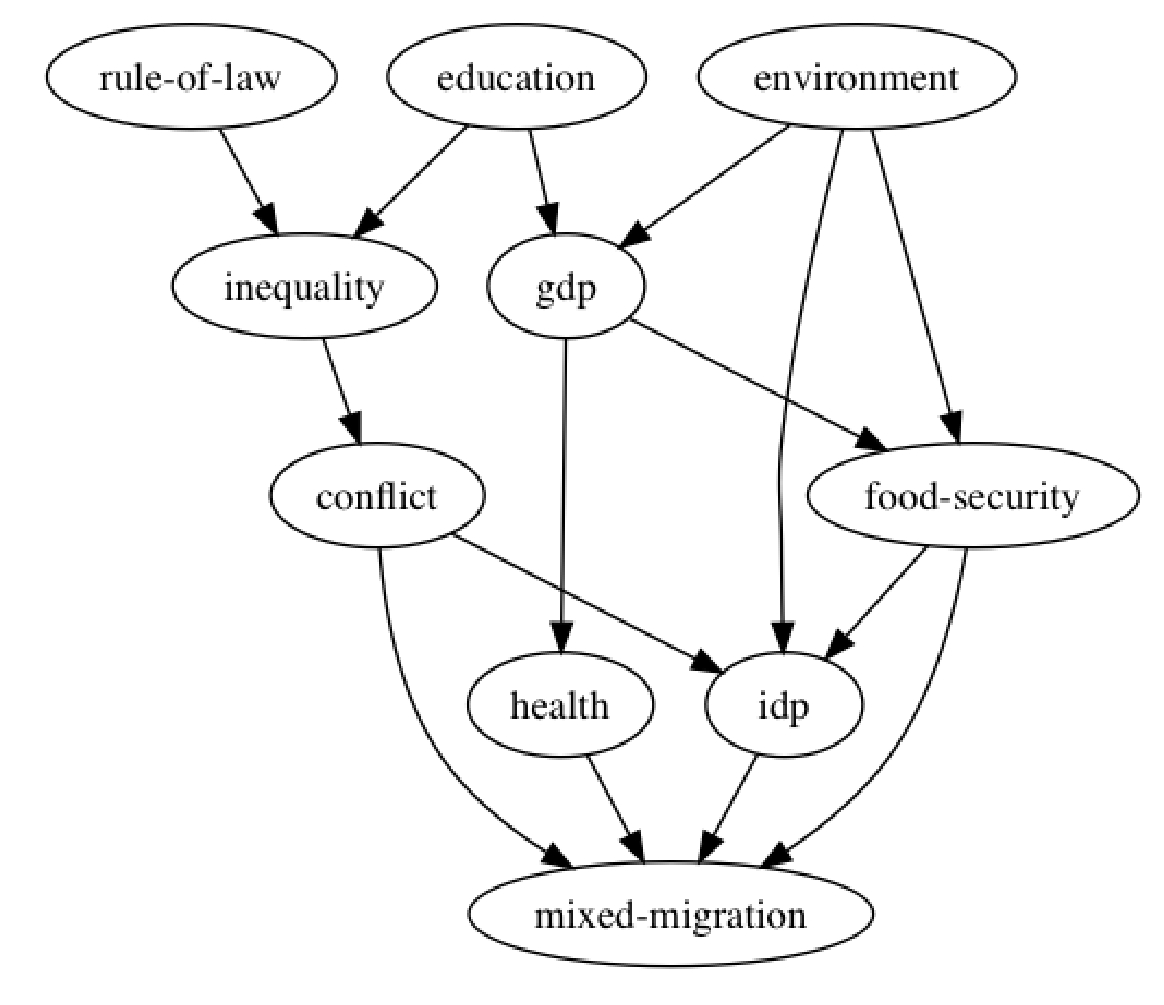

In [128]:
G = networkx.DiGraph()
cols = X.columns.tolist()

nodes = {} # node to ID dictionary


with open("network.json", 'rt') as infile:
    net = json.load(infile)


# Driver clusters (node sets) from expert-network
for clus, indicator in net['nodes'].items():
    
    # build the index sets based on the data
    index = []
    for i in indicator:
        try:
            index.append(cols.index(i))
        except ValueError:
            raise ValueError("{} indicator not in data.".format(i))
    
    nodes[clus] = index

# Map the edges
edge_count = 0
for clus, to_nodes in net['edges'].items():
    
    fidx = nodes[clus]
    
    for tn in to_nodes:
        
        tidx = nodes[tn]
        
        if fidx and tidx:
        
            G.add_edge(tuple(fidx), tuple(tidx))
            edge_count += 1

print("Domain network with {} node clusters and {} edges.".format(len(nodes), edge_count))
nlabels = {tuple(v):k for k, v in nodes.items()}
plot_networkx(G, node_label=nlabels)

In [130]:
start_time = time()
model = BayesianNetwork.from_samples(X, 
                                     algorithm='exact',
                                     state_names=X.columns,
                                     constraint_graph=G,
                                     n_jobs=-1)
print("Structure learning (constrained) in {:3.2f} sec.".format(time() - start_time))

Structure learning (constrained) in 60.66 sec.


In [149]:
plot_model(model)

/Users/rahul/anaconda3/envs/prm/lib/python3.5/site-packages/pygraphviz/agraph.py:1334: RuntimeWarning: Warning: Overlap value "prism" unsupported - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)
